In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy.special import expit, logit

from bids import BIDSLayout

import pymc3 as pm
from theano import tensor as tt
import arviz as az

In [2]:
BIDS_ROOT = 'bids_dataset'

In [3]:
# prepare trial data for multilevel model
layout = BIDSLayout(BIDS_ROOT)
ev_files = layout.get(
    return_type = 'file', 
    suffix = 'events',
    extension = 'tsv'
)
events = []
for i, f in enumerate(ev_files):
    ev = pd.read_csv(f, sep = '\t')
    ev = ev[ev.trial_type.str.contains('random')]
    ev['subject'] = np.full(ev.shape[0], i)
    events.append(ev)
events = pd.concat(events)

/home/johnv/anaconda3/envs/daf/lib/python3.9/site-packages/bids/layout/models.py:148: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


In [4]:
n_sub = len(layout.get_subjects())
n_param = 4

model = pm.Model()
with model:
    
    # grouping variable
    sub = pm.Data('subject', events.subject.to_numpy())
    delay = pm.Data('delay', events.delay.to_numpy())
    post = pm.Data('post-adaption', (events.trial_type.to_numpy() == 'random2').astype(int))
    
    # priors for population-level parameters
    p0 = pm.Beta('p0', 1, 3) # probability of detection at zero delay
    b0 = pm.Deterministic('b0', pm.logit(p0)) # intercept
    b1 = pm.Exponential('b1', .1) # effect of delay, must be positive -- on scale of delay
    b2 = pm.Normal('b2', 0, 1) # effect of adaption -- unitless
    b3 = pm.Normal('b3', 0, 10) # interaction
    
    # multivariate normal distribution of subject-specific params (uncentered)
    z = pm.Normal("z", 0.0, 1.0, shape = (n_param, n_sub))
    chol, corr, stds = pm.LKJCholeskyCov( # correlation matrix
        "chol", 
        n = n_param, 
        eta = 2.0, 
        sd_dist = pm.Exponential.dist(1), 
        compute_corr = True
    )
    offsets = tt.dot(chol, z).T # MVNormal draws, n_sub x n_param
    b0_sub = pm.Deterministic('b0_sub', b0 + offsets[:, 0])
    b1_sub = pm.Deterministic('b1_sub', b1 + offsets[:, 1])
    b2_sub = pm.Deterministic('b2_sub', b2 + offsets[:, 2])
    b3_sub = pm.Deterministic('b3_sub', b3 + offsets[:, 3])
    
    # logistic regression model given subject-specific params
    theta = b0_sub[sub] + b1_sub[sub]*delay + b2_sub[sub]*post + b3_sub[sub]*post*delay
    p = pm.invlogit(theta)
    y = pm.Bernoulli('y', p, observed = events.detected_delay.to_numpy())

In [5]:
with model:
    trace = pm.sample(
        2000, 
        target_accept = 0.9,
        random_seed = 1,
        return_inferencedata = True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [chol, z, b3, b2, b1, p0]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 423 seconds.
The number of effective samples is smaller than 10% for some parameters.


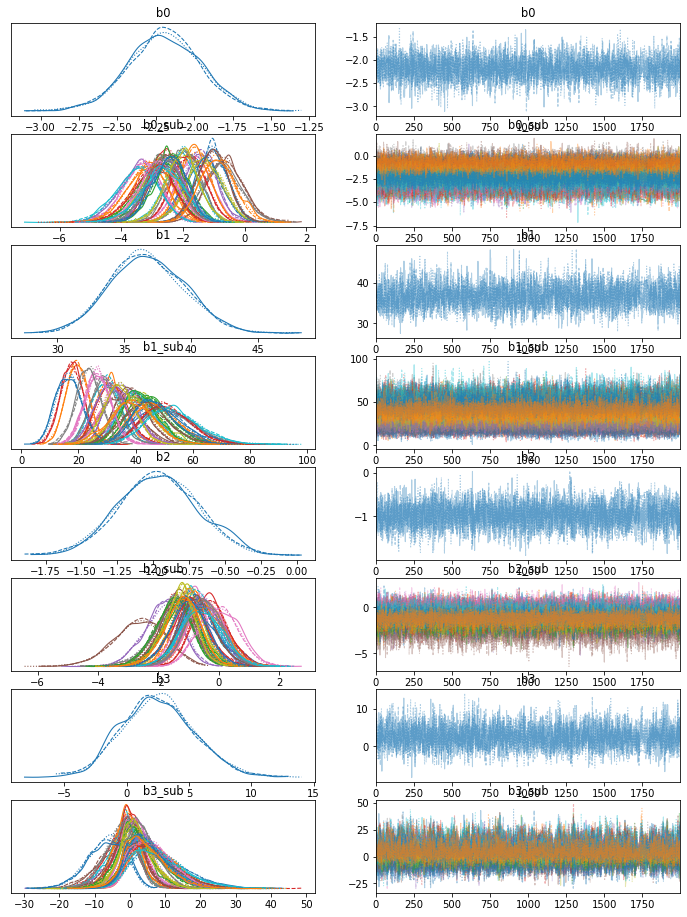

In [6]:
ax = az.plot_trace(trace, var_names = ['b0', 'b0_sub', 'b1', 'b1_sub', 'b2', 'b2_sub', 'b3', 'b3_sub'])

In [7]:
hdi_prob = .90
az.hdi(trace, hdi_prob, var_names = ['p0', 'b0', 'b1', 'b2', 'b3'])

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    p0       (hdi) float64 0.06831 0.1393
    b0       (hdi) float64 -2.569 -1.787
    b1       (hdi) float64 32.08 41.14
    b2       (hdi) float64 -1.431 -0.5158
    b3       (hdi) float64 -2.196 7.261

In [8]:
# gather samples for population parameters 
trc = trace.posterior.stack(draws = ("chain", "draw"))
b0 = trc['b0'].values
b1 = trc['b1'].values
b2 = trc['b2'].values
b3 = trc['b3'].values

In [9]:
(b2 < 0).mean() # probability of adapation for population

0.9996666666666667

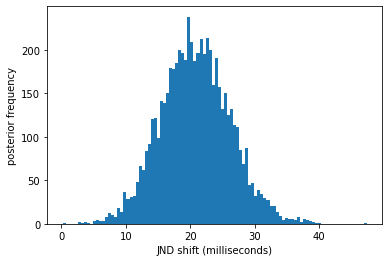

The point of 50% detection shifts from 59.7 ms to 80.6 ms or by 20.8 ms on average.
The 90.0% HDI of the shift is: (11.8 ms, 29.1 ms)


In [10]:
jnd1 = (logit(1/2) - b0)/(b1) * 1e3
jnd2 = (logit(1/2) - b0 - b2)/(b1 + b3) * 1e3
delta = jnd2 - jnd1
ax = plt.hist(delta, bins = 100)
plt.xlabel('JND shift (milliseconds)')
plt.ylabel('posterior frequency')
plt.show()
print('The point of 50% detection shifts from {:.1f} ms to {:.1f} ms '.format(jnd1.mean(), jnd2.mean()) + 
      'or by {:.1f} ms on average.'.format(delta.mean()))
hdi = az.hdi(delta, hdi_prob)
print('The {:.1f}% HDI of the shift is: ({:.1f} ms, {:.1f} ms)'.format(hdi_prob * 100, hdi[0], hdi[1]))

In [11]:
# get posterior for predicted probabilities
t_max = np.max(events.delay)
x = np.stack([np.linspace(0, t_max, 500) for i in range(b0.shape[0])], axis = 1)
p1 = expit(b0 + b1*x)
p2 = expit((b0 + b2) + (b1 + b3)*x)

/tmp/ipykernel_408535/3061707123.py:4: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(p.T, hdi_prob)
/tmp/ipykernel_408535/3061707123.py:4: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(p.T, hdi_prob)


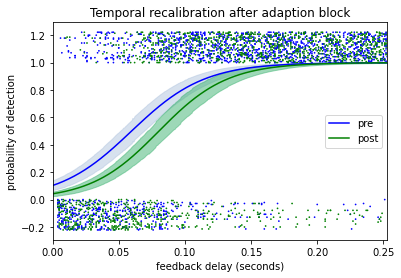

In [18]:
def plot_hdi(x, p, label, mean_col = 'blue', hdi_col = 'lightsteelblue'):
    m = p.mean(1)
    hdi = az.hdi(p.T, hdi_prob)
    plt.fill_between(x[:,0], hdi[:,0], hdi[:,1], color = hdi_col, alpha = .5)
    plt.plot(x[:,0], m, color = mean_col, label = label)

plot_hdi(x, p1, 'pre') # before adaption
plot_hdi(x, p2, 'post', 'green', 'mediumseagreen') # after adaption
col = np.where(events.trial_type.to_numpy() == 'random2', 'green', 'blue')
sub_off = 140
off = np.where(events.detected_delay.to_numpy(), 0, -1 * (n_sub - 1)/sub_off)
jitter = events.subject/sub_off + off # each subject gets their own row
plt.scatter(events.delay, events.detected_delay + jitter, color = col, s = .5)
plt.xlabel('feedback delay (seconds)')
plt.ylabel('probability of detection')
plt.legend(labels = ['pre', 'post'])
plt.title('Temporal recalibration after adaption block')
plt.xlim(0., t_max)
plt.show()

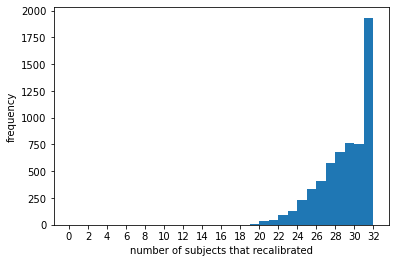

With probability 0.95, at least 23 out of 32 people recalibrated.


In [19]:
# how many subjects recalibrated?
b2_sub = trc['b2_sub'].values
n_recal = (b2_sub < 0).sum(axis = 0) # number of subjects who recalibrated in each posterior sample
plt.hist(n_recal, bins = n_sub, range = (0, n_sub))
plt.xticks([i for i in range(n_sub + 1) if i % 2 == 0])
plt.xlabel('number of subjects that recalibrated')
plt.ylabel('frequency')
plt.show()

recal_prob = .95
n_recal = np.percentile(n_recal, 100*(1 - recal_prob))
print(
    'With probability {:.2f}, at least {:.0f} out of {:.0f} people recalibrated.'.format(
        recal_prob, n_recal, n_sub
    )
)

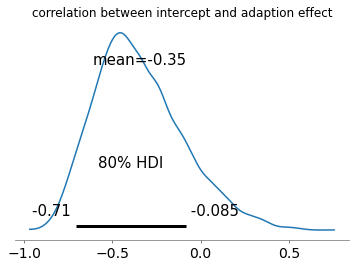

In [14]:
ax = az.plot_posterior(trc['chol_corr'].values[0, 2, :], hdi_prob = hdi_prob)
plt.title('correlation between intercept and adaption effect')
plt.show()

The intercept coefficient $\beta_0$, per the model specification, represents the baseline probability of detecting a delay when the delay is actually zero (i.e. a false positive), but since no _true_ zero delays exist in the dataset due to a ~4 ms hardware delay, one could also argue it reflects the sensitivity to very, very small delays. Adaption is evidenced by a negative $\beta_2$, so a negative correlation between $\beta_0$ and $\beta_2$ means that higher baseline detection probabilities herald greater temporal recalibration.

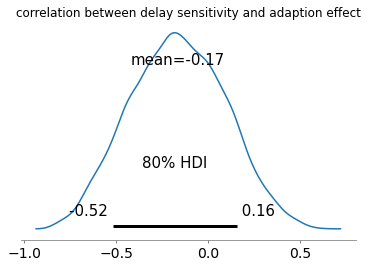

In [15]:
ax = az.plot_posterior(trc['chol_corr'].values[1, 2, :], hdi_prob = hdi_prob)
plt.title('correlation between delay sensitivity and adaption effect')
plt.show()